In [89]:
pd.set_option('display.max_columns', 500)

print(packages_import_statement)

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

import re
import time 

from pprint import pprint




In [90]:
# Get geographic data for each CD
cb_by_borough = pd.read_csv("../data/nta_to_cb_clean.csv",skiprows=4,header=1)[['Borough','Unnamed: 4','Neighborhood Tabulation Area (NTA)']].iloc[1:]
cb_by_borough.columns = ['Borough',"CD","NTA"]
borough_to_code_dict =  {"MN":1
    ,"BX":2
    ,"BK":3
    ,"QN":4
    ,"SI":5}
def make_cb_index_code(row):
    b_code = borough_to_code_dict[row["CD"][0:2]]
    cd_code = row['CD'].split(" ")[-1]
    if len(cd_code)==1:
        cd_code = f"0{cd_code}"
    return f"{b_code}__{cd_code}"
cb_by_borough['communitydistrict_index']=cb_by_borough.apply(make_cb_index_code,axis=1)
cb_by_borough= cb_by_borough[['Borough','communitydistrict_index']].drop_duplicates().reset_index(drop=True)
cb_by_borough.sample(5)

,Borough,communitydistrict_index
38,Manhattan,1__06
44,Queens,4__07
24,Brooklyn,3__10
37,Manhattan,1__05
33,Manhattan,1__11


In [91]:
def test_train_cds_by_borough(train_ratio=.72):
    
    test_cds = list()
    train_cds = list()
    
    for boro in cb_by_borough["Borough"].unique():
        boro_df = cb_by_borough[cb_by_borough['Borough']==boro]
#         print(boro)
#         print()
        train_cds.extend(boro_df.sample(int(train_ratio*len(boro_df)//1))['communitydistrict_index'].values)
        test_cds.extend(boro_df[~boro_df['communitydistrict_index'].isin(train_cds)]['communitydistrict_index'].values)
        
    return train_cds,test_cds
        
train_cds, test_cds = test_train_cds_by_borough()
print(f"# Train CDs: {len(train_cds)}")
print(f"# Test CDs: {len(test_cds)}")




# Train CDs: 40
# Test CDs: 19


In [92]:
##target variable
diversion_ratechange = pd.read_csv("../modeling_data/Y__Diversion_RateChange.csv")

## input variables_CENSUS
demos = pd.read_csv("../modeling_data/Xs_ACS_DemoData.csv")
econs = pd.read_csv("../modeling_data/Xs_ACS_EconData.csv")

#LOAD DATA IN, JOIN TOGETHER XS AND Y
modeling_df = diversion_ratechange.merge(demos,on='communitydistrict_index',how='left').merge(econs,on='communitydistrict_index',how='left').set_index("communitydistrict_index")
st_scaler = StandardScaler()
modeling_df_scaled = pd.DataFrame(st_scaler.fit_transform(modeling_df),index=modeling_df.index,columns=modeling_df.columns)
train = modeling_df_scaled.loc[train_cds]
train_X = train.drop(["Change_Diversion_Rate_PostLockdown"],axis=1)
train_Y = train[["Change_Diversion_Rate_PostLockdown"]]

test = modeling_df_scaled.loc[test_cds]
test_X = test.drop(["Change_Diversion_Rate_PostLockdown"],axis=1)
test_Y = test[["Change_Diversion_Rate_PostLockdown"]]


In [93]:
len(train),len(test)

(40, 19)

In [94]:
display(train_X.head(2)),display(train_Y.head(2))

,pop_under_18,pop_over_65,white_alone,black_alone,hispanic,asian_alone,other_race_alone,num_employed,num_unemployed,hh_inc<10K,hh_inc10-14K,hh_inc15-24K,hh_inc25-34K,hh_inc35-49K,hh_inc50-74K,hh_inc75-99K,hh_inc100-149K,hh_inc150-199K,hh_inc>200K,hh_with_snap_past12mos,num_eployed_info_sector,num_eployed_fire_sector,num_eployed_sciences_waste_sector,num_eployed_educhealthsocial_sector,num_eployed_artsentertainmentfoood_sector,num_eployed_other_sector,num_eployed_publicadmin_sector
communitydistrict_index,,,,,,,,,,,,,,,,,,,,,,,,,,,
2__07,0.271976,-1.140739,-1.054734,-0.384726,1.453033,-0.605768,-0.249586,-0.807130,1.030153,0.277700,0.500056,0.443947,0.598124,0.167930,-0.223849,-1.024317,-1.398971,-1.246736,-0.698224,1.066178,-0.933495,-0.629858,-0.835237,-0.542036,0.311543,0.223308,-1.234902
2__06,1.662631,-0.695120,-1.071575,0.549090,1.878112,-0.866657,-0.355786,-0.602101,2.286521,2.301234,2.332754,2.224951,1.520440,1.031987,-0.373856,-1.394773,-1.400931,-1.294219,-0.699199,2.584112,-0.833500,-0.667437,-0.745562,0.173107,-0.117495,0.046578,-0.849799


,Change_Diversion_Rate_PostLockdown
communitydistrict_index,
2__07,2.301363
2__06,1.716128


(None, None)

In [95]:
# Taking professors function on regularization c
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

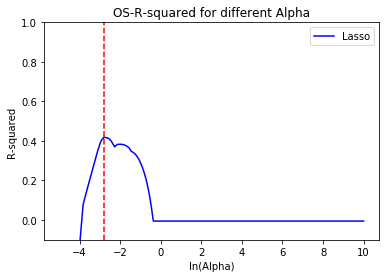

Optimal alpha for Lasso=0.06103672004531974, best OS R_2=0.41896125301145126


In [96]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha\
(2,train_X,train_Y,test_X,test_Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

In [108]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

rel_coefs = list()
Lasso.fit(train_X,train_Y)
for col,coef in zip(train_X.columns,Lasso.coef_):
    if coef>0:
        rel_coefs.append([col, coef])
        
coefs_lasso = pd.DataFrame(rel_coefs,columns=['Column Name',"Coefficient"]).sort_values(by='Coefficient',ascending=False)
coefs_lasso

,Column Name,Coefficient
1,hh_inc15-24K,0.380861
2,hh_inc50-74K,0.272759
3,hh_with_snap_past12mos,0.121700
0,other_race_alone,0.013373
4,num_eployed_other_sector,0.006696


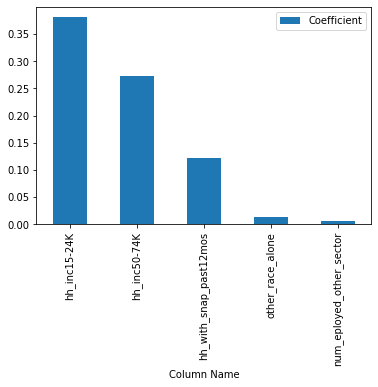

In [111]:
coefs_lasso.plot(kind='bar',x='Column Name',y='Coefficient')

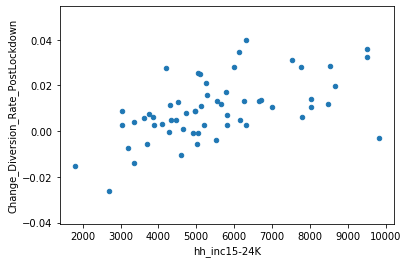

In [115]:
modeling_df[['hh_inc15-24K','Change_Diversion_Rate_PostLockdown']].plot(kind='scatter',x='hh_inc15-24K',y='Change_Diversion_Rate_PostLockdown')